In [1]:
%load_ext autoreload
%autoreload 2

from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os,sys
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"
sys.path.append('../scripts/')
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pickle
import jax.numpy as jnp

import jaxley as jx

from nex.colors import cols as papercols
from Lyaponuv import  obtain_max_Lyapunov
from network import initialize_RNN as initialise_DMS_RNN


<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Toggle to load already calculated Lyaponuv exponents
load_data = True

In [3]:
# set params of RNN

g_scaling = 100_000 / 2 / np.pi / 10.0 / 1.0
dt = .025
RNN_params = {
    "RNN_seed":4,
    "n_rec":50,
    "n_inh":10,
    "n_out":2,
    "init_gain": 4/g_scaling,
    "out_scale":.1,
    "inp_scale":1,
    "in_conn_prob":.1,
    "out_conn_prob":1,
    "rec_conn_prob":.2,
    "k_minus":1,
    "out_k_minus":.1,
}



In [4]:
# Load exponents

if load_data:
    with open("../results/DMS_Lyapunov7.pkl", "rb") as f:
        results =pickle.load(f)
    Ls = results["Lyapunov"]
    gs = results["gains"]

# or obtain:
else:
    n_models = 1
    T = int(6000/dt)
    transient=int(2000/dt)
    renormalise_interval = 1#10/dt
    n_repeats_per_model = 1
    gstep = .00025
    gs = np.concatenate([np.arange(0,.003+gstep,gstep)]*n_models)
    seeds = np.int_(np.concatenate([np.ones(int(len(gs)/n_models))*i for i in range(n_models)]))
    Ls = []
    for s,g in zip(seeds,gs):
        RNN_params['init_gain'] = g
        RNN_params['RNN_seed'] = s
        network, conn_matrix, input_weights=initialise_DMS_RNN(RNN_params)
        L,_ = obtain_max_Lyapunov(network,dt=dt,transient = transient,T=T,n_repeats=n_repeats_per_model,QR_t=renormalise_interval)
        Ls.append(np.max(L))
        print(np.max(L))
    Ls= np.array(Ls)
    results = {"gains":gs, "Lyapunov":Ls}
    with open("../results/DMS_Lyapunov8.pkl", "wb") as f:
        pickle.dump(results, f)

In [5]:
# Initialise 3 models corresponding to different dynamical regimes

gains = [0.00075, 0.00125, 0.00275]
RNN_params['init_gain']=gains[0]
network1, conn_matrix, input_weights=initialise_DMS_RNN(RNN_params)
RNN_params['init_gain']=gains[1]
network2, conn_matrix, input_weights=initialise_DMS_RNN(RNN_params)
RNN_params['init_gain']=gains[2]
network3, conn_matrix, input_weights=initialise_DMS_RNN(RNN_params)

10.36
518
50
conn probability recurrence: 0.2072
EIratio:4.0
Normaliser: 0.5366449310309914
Spectral radius recurrence: 0.0009447591211556599
10.36
518
50
conn probability recurrence: 0.2072
EIratio:4.0
Normaliser: 0.5366449310309914
Spectral radius recurrence: 0.001574598535259436
10.36
518
50
conn probability recurrence: 0.2072
EIratio:4.0
Normaliser: 0.5366449310309914
Spectral radius recurrence: 0.0034641167775707523


In [6]:
# Add recordings

network1.delete_recordings()
# Record from the soma of each cell
for i in range(RNN_params['n_rec']):
    network1.cell([i]).branch(1).comp(0).record(verbose=False)
# Record from the readout (only one branch)
for i in range(RNN_params['n_out']):
    network1.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)

network2.delete_recordings()
# Record from the soma of each cell
for i in range(RNN_params['n_rec']):
    network2.cell([i]).branch(1).comp(0).record(verbose=False)
# Record from the readout (only one branch)
for i in range(RNN_params['n_out']):
    network2.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)

network3.delete_recordings()
# Record from the soma of each cell
for i in range(RNN_params['n_rec']):
    network3.cell([i]).branch(1).comp(0).record(verbose=False)
# Record from the readout (only one branch)
for i in range(RNN_params['n_out']):
    network3.cell([RNN_params['n_rec']+i]).branch(0).comp(0).record(verbose=False)
     

In [7]:
# Simulate

# cut of transients
t_max = 1400 # ms
transient = 1000
levels = 3
checkpoints = [int(np.ceil(t_max ** (1/levels))) for _ in range(levels)]
v1 = jx.integrate(network1, t_max=t_max-1*dt, delta_t=dt, solver="bwd_euler")#,checkpoint_lengths=checkpoints)
v2 = jx.integrate(network2, t_max=t_max-1*dt, delta_t=dt, solver="bwd_euler")#,checkpoint_lengths=checkpoints)
v3 = jx.integrate(network3, t_max=t_max-1*dt, delta_t=dt, solver="bwd_euler")#,checkpoint_lengths=checkpoints)
v1 = v1[:,int(transient/dt):]
v2 = v2[:,int(transient/dt):]
v3 = v3[:,int(transient/dt):]


In [11]:
papercols["jaxley_shades"]

['#d0d1e6', '#a6bddb', '#74a9cf', '#3690c0', '#0570b0', '#045a8d', '#023858']

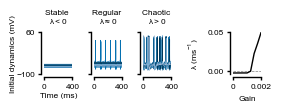

In [16]:
# Make plot

time = np.arange(0, t_max-transient, dt)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 4, figsize=(2.7, 1.0), constrained_layout=True)
    ax[0].set_prop_cycle('color',papercols["jaxley_shades"][1:])
    ax[1].set_prop_cycle('color',papercols["jaxley_shades"][1:])
    ax[2].set_prop_cycle('color',papercols["jaxley_shades"][1:])

    ax[0].plot(time,v1[:RNN_params['n_rec'],0:].T,lw=.5);
    ax[1].plot(time,v2[:RNN_params['n_rec'],0:].T,lw=.5);
    ax[2].plot(time,v3[:RNN_params['n_rec'],0:].T,lw=.5);
    n_models = 3
    for i in [1]:
        i1 = int(i*len(gs)/n_models)
        i2=int((i+1)*len(gs)/n_models)
        ax[3].plot(gs[i1:i2],Ls[i1:i2], color= 'black',alpha=1, zorder = 10)#,lw=.5)
    ax[3].axhline(0,ls='--',color='grey',lw=.5)

    for a in ax[:3]:
        a.set_xticks([0,t_max-transient])
        a.set_xlim(0,t_max-transient)
        a.set_ylim(-100, 60)
        a.set_yticks([-100, 60])
        sns.despine(offset=2)
    for a in ax[1:3]:
        a.set_yticklabels([])
    ax[0].set_title("Stable \n"+r"$\lambda<0$")
    ax[1].set_title("Regular \n"+r"$\lambda	\approx0$")
    ax[2].set_title("Chaotic \n"+r"$\lambda>0$")
    ax[0].set_ylabel("Initial dynamics (mV)", labelpad=0)
    ax[0].set_xlabel("Time (ms)", labelpad=2)
    
    ax[3].set_xlim(0,0.002)
    ax[3].set_ylim(-0.004,0.05)
    ax[3].set_xlabel('Gain')
    ax[3].set_ylabel(r'$\lambda \;({ms}^{-1})$')
    ax[3].set_xticks([0,0.002])
    ax[3].set_xticklabels([0,0.002])
    plt.savefig("../figures/dms_initial_dynamics.svg", transparent=True)
    plt.show()
